<h1><center>CQF Program - Final project code</center></h1>

<h2><center>Angelo Rafael Lenarte Homen</center></h2>

<h1><center>Long/Short Trading Strategies Design & Backtest (TS)</center></h1>

_"A pairs trade or pairs trading is a market neutral trading strategy enabling traders to profit from virtually any market conditions: uptrend, downtrend, or sideways movement. This strategy is categorized as a statistical arbitrage and convergence trading strategy. Pairs trading was pioneered by Gerry Bamberger and later led by Nunzio Tartaglia's quantitative group at Morgan Stanley in the 1980s. The strategy monitors performance of two historically correlated securities. When the correlation between the two securities temporarily weakens, i.e. one stock moves up while the other moves down, the pairs trade would be to short the outperforming stock and to long the underperforming one, betting that the "spread" between the two would eventually converge. The divergence within a pair can be caused by temporary supply/demand changes, large buy/sell orders for one security, reaction for important news about one of the companies, and so on. Pairs trading strategy demands good position sizing, market timing, and decision making skill. Although the strategy does not have much downside risk, there is a scarcity of opportunities, and, for profiting, the trader must be one of the first to capitalize on the opportunity."_

This working code designs a pairs trading strategy based on numerical methods as Engle-Granger procedure, Augmented Dickey-Fuller test and Onstein-Uhlenbeck process applied to analyze the cointegration between Soybean Futures and Soybean Meal Futures.

# Importing libraries and setting some parameters

In [1]:
# Importing libraries
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pyfolio as pf
import warnings

from numpy import *
from src.pairs_trading import PairsTrading

warnings.filterwarnings("ignore")
plt.style.use('seaborn-whitegrid')

pt = PairsTrading

C:\Users\Angelo\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


# Defining money to trade

Define how much money to trade distributed to both stocks.

In [14]:
########################################################################
# How much money will be used to trade.                                #
########################################################################
money = 10000

# Defining stocks to be cointegrated

Stock 1 ticker:

In [15]:
########################################################################
# Choose stock 1 to cointegration analysis.                            #
########################################################################
stock1 = 'ZS=F'

Stock 2 ticker:

In [16]:
########################################################################
# Choose stock 2 to cointegration analysis.                            #
########################################################################
stock2 = 'ZM=F'

## Downloading and preprocessing data

Choose datetimes of beginning and ending to download both stocks. Then set a percentage of training data. Stardard is 70% and it is the same to say that 70% of downloaded data will be used just for strategy design and the other 20% will validate it. This piece of code will download both stocks data, apply datetime correction function to it and separate 'train' and 'test' dataframes.

In [17]:
########################################################################
# Datetime to analyze- begin and end.                                  #
########################################################################
init_datetime = '1990-01-01'
final_datetime = '2021-12-31'
train_percentage = 0.7 # Percentage of data to train

In [18]:
########################################################################
# Download and adjust all data.                                        #
########################################################################
both_stock_dataframe, two_dataframes_train, two_dataframes_test = pt.data_download_and_adjust(stock1, stock2, init_datetime, final_datetime, train_percentage)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Data preprocessing

Just separating both stocks now that they are corrected and correctly related. Plotting both ajusted close prices.

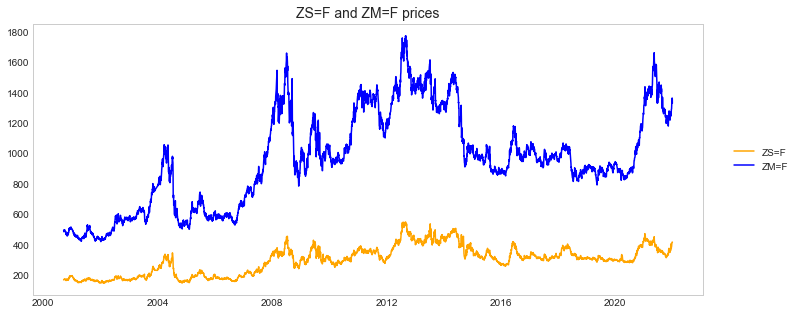

In [19]:
########################################################################
# Separate each stock to dataframe - ready to analyze.                 #
########################################################################
price_a_train = two_dataframes_train.iloc[:, 0]
price_b_train = two_dataframes_train.iloc[:, 1]

# Plot both stocks
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)
    
plt.plot(both_stock_dataframe.iloc[:, 0], color='orange', label=stock1)
plt.plot(both_stock_dataframe.iloc[:, 1], color='b', label=stock2)
plt.grid(b=False)
plt.title(f'{stock1} and {stock2} prices', fontsize=14)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0);

# Engle-Granger first step

First step of Engle-Granger procedure is to estimate the model:

<center><b> <i>[ZM=F]</i>$_t  =  \beta . $<i> [ZS=F]</i>$_t + \mu_e + \epsilon_t$ </b></center>

In [20]:
########################################################################
# There's print dataframe, residuals series, residuals dataframe,      #
# linear regression constant and estimation coefficient. All variables #
# are used in codes sequence.                                          #
########################################################################
eg_step_1_show_fw, e_t_fw, e_t_df_fw, mu_e_fw, beta_coint_fw = pt.linear_regression(price_a_train, price_b_train)
eg_step_1_show_fw

Pairs trading parameters:
μ_e = -1.6700
β_coint = 3.3154



Estimate ZM=F  SD of Estimate ZM=F  t-statistic ZM=F
Constant      -1.669971             4.785101         -0.348994
ZS=F           3.315447             0.015822        209.549990

and so, **NAIVE** cointegrated residual is:

<center><b> $\epsilon_t = $<i>[ZM=F]</i>$_t  - $3.3154$ . $ <i>[ZS=F]</i>$_t + $1.6700 </b></center>

where:

<center><b> $\beta_{coint} = [$1, $-$ 3.3154$]$ and $\mu_e = -$ 1.6700</b></center>

The question now is whether the residual series is stationary -- has no unit root (randomness). We perform Augmented Dickey-Fuller Test on this Cointegrated residual.

**NAIVE COINTEGRATING RELATIONSHIP** Regressing one equity price on another arbitrarily does not create cointegration. This is a first step in the analysis of a potential long-run relationship between the two time series $P_t^A$ and $P_t^B$.

# Augmented Dickey-Fuller Test at Residuals

ADF test equation:

$$\Delta e_t = \Phi e_{t-1} + \Phi_{aug1} \Delta e_{t-1} + const + \Phi_t t + \epsilon_t$$

Test equation above includes time dependence $\Phi_t t$, referred to as 'trend'. I'll not include trend in ADF tests and cointegrating residual -- it would make us think cointegration is present when it is very weak. In fact, without $\Phi_t t$ term, we might not even get stationarity result.

In [21]:
########################################################################
# Print dataframe.                                                     #
########################################################################
adf_test_show_fw, adf_train_fw, adf_stat_fw = pt.aug_dickey_fuller(e_t_fw, stock2)
adf_test_show_fw

Augmented Dickey-Fuller Test:
ADF Statistics = -3.6850
ADF p_value = 0.0043
1% = -3.4321
5% = -2.8623
10% = -2.5672

p_value (0.0043) is less than 0.05.
We can reject the null hypothesis with a significance level of less than 1%.
The process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.


Estimate ΔZM=F  SD of Estimate ΔZM=F  t-statistic ΔZM=F
Constant                  -0.024837              0.222831          -0.111459
(Lag 1, Res(ZM=F))        -0.008348              0.002265          -3.685018
(Lag 1, ΔRes(ZM=F))       -0.096158              0.016390          -5.867023

# Engle-Granger second step

## First way

Engle-Granger procedure second step is to estimate the Equilibrium Correction Model, or error correction equations, in general form:

$$\Delta P_t^A = \Phi \Delta P_t^B - (1 - \alpha)ê_{t-1} + \epsilon_t$$

To this study case:

<center><b>$\Delta$<i>[ZM=F] </i>$_t=\Phi\Delta$<i>[ZS=F]</i> $_t - (1 - \alpha) $<i>Coint_[ZM=F]</i>_<i>[ZS=F]</i>$ + \epsilon_t$</b></center>

In error correction equation the  p -value is evaluated agaist t-distribution as is common for regression. 

In [22]:
########################################################################
# Print dataframe.                                                     #
########################################################################
eg_step_2_show_fw, e_g_test_fw = pt.second_step_engle_granger(price_a_train, price_b_train, e_t_fw)
eg_step_2_show_fw

Estimate ΔZM=F  SD of Estimate ΔZM=F  t-statistic ΔZM=F  \
ΔZS=F                     0.279721              0.003566          78.431439   
(Lag 1, Res(ZM=F))        0.002922              0.000681           4.287749   

                     p_value  p_value < 0.05?  
ΔZS=F               0.000000             True  
(Lag 1, Res(ZM=F))  0.000019             True

In error correction equation the p_values are evaluated agaist t-distribution as is common for regression. We will reject null hypotesis that a regression coefficient is zero if the corresponding p_value is less than 0.05. In the table above "True" value at 'p_value < 0.05?' column indicates a regression coefficient that is siginificantly different from zero.

## Other way around

Now, we can estimate Engle-Granger Correction Equation "other way around":

<center><b>$\Delta$<i>[ZS=F] </i>$_t=\Phi\Delta$<i>[ZM=F]</i> $_t - (1 - \alpha) $<i>Coint_[ZS=F]</i>_<i>[ZM=F]</i>$ + \epsilon_t$</b></center>

In [23]:
########################################################################
# All other way around.                                                #
########################################################################
eg_step_1_show_ow, e_t_ow, e_t_df_ow, mu_e_ow, beta_coint_ow = pt.linear_regression(price_b_train, price_a_train)
eg_step_1_show_ow

Pairs trading parameters:
μ_e = 22.5364
β_coint = 0.2782



Estimate ZS=F  SD of Estimate ZS=F  t-statistic ZS=F
Constant      22.536449             1.335657         16.872927
ZM=F           0.278220             0.001328        209.549990

In [24]:
########################################################################
# All other way around.                                                #
########################################################################
eg_step_2_show_ow, e_g_test_ow = pt.second_step_engle_granger(price_b_train, price_a_train, e_t_ow)
eg_step_2_show_ow

Estimate ΔZS=F  SD of Estimate ΔZS=F  t-statistic ΔZS=F  \
ΔZM=F                     2.233669              0.028506          78.356856   
(Lag 1, Res(ZS=F))        0.012347              0.006664           1.852675   

                     p_value  p_value < 0.05?  
ΔZM=F               0.000000             True  
(Lag 1, Res(ZS=F))  0.064009            False

and so, **NAIVE** cointegrated residual is:



<center><b> $\epsilon_t = $<i>[ZS=F]</i>$_t  - $0.2782$ . $ <i>[ZM=F]</i>$_t + $22.5364 </b></center>

where:

<center><b> $\beta_{coint} = [$1, $-$ 0.2782$]$ and $\mu_e = $22.5364 </b></center>

# Augmented Dickey-Fuller Test at Residuals - 'Other way around'

We'll apply same ADF test but to other way around estimation, witch now uses previous independent variable as dependent variable and previous dependent variable as independent variable.

In [25]:
########################################################################
# Print dataframe.                                                     #
########################################################################
adf_test_show_ow, adf_train_ow, adf_stat_ow = pt.aug_dickey_fuller(e_t_ow, stock1)
adf_test_show_ow

Augmented Dickey-Fuller Test:
ADF Statistics = -3.8503
ADF p_value = 0.0024
1% = -3.4321
5% = -2.8623
10% = -2.5672

p_value (0.0024) is less than 0.05.
We can reject the null hypothesis with a significance level of less than 1%.
The process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.


Estimate ΔZS=F  SD of Estimate ΔZS=F  t-statistic ΔZS=F
Constant                   0.010158              0.066949           0.151723
(Lag 1, Res(ZS=F))        -0.009048              0.002350          -3.850338
(Lag 1, ΔRes(ZS=F))       -0.084483              0.016408          -5.148882

# Best estimation selection

This piece of code selects the best cointegration results based on ADF test and Engle-Granger procedure second step.

In [26]:
########################################################################
# Based on Engle_Granger procedure and ADF test now we can choose the  #
# best way to estimate our cointegration analysis. We'll compare       #
# result from first way (_fw) and other way (_ow).                     #
########################################################################

########################################################################
############################## Residuals ###############################
e_t = []
mu_e = 0
beta_coint = 0
adf_train = False
e_g_test = False
stock = ''

############################### X and Y ################################

# First way: X is stock1 and Y is stock2
# Other way: X is stock2 and Y is stock1
# Code is prepared to first way, if the other way is better, there's 
# the necessity to update all data the other way around.

# If fw passed at ADF test and ow not
if adf_train_fw and not adf_train_ow:
    
    e_t = e_t_fw
    mu_e = mu_e_fw
    beta_coint = beta_coint_fw
    adf_train = adf_train_fw
    e_g_test = e_g_test_fw
    stock = stock2
    
    print('ESTIMATION BASED ON FIRST WAY. First way estimation passed at ADF test and other way not.')
    print()
    
    if e_g_test:
        print('Engle-Granger second step procedure approved to first way estimation.')
    else:
        print('WARNING: Engle-Granger second step procedure was not approved to first way estimation.')
    
# If ow passed at ADF test and fw not
if not adf_train_fw and adf_train_ow:
    
    e_t = e_t_ow
    mu_e = mu_e_ow
    beta_coint = beta_coint_ow
    adf_train = adf_train_ow
    e_g_test = e_g_test_ow
    stock = stock1
    
    print('ESTIMATION BASED ON OTHER WAY. Other way estimation passed at ADF test and first way not.')
    print()
    
    if e_g_test:
        print('Engle-Granger second step procedure approved to other way estimation.')
    else:
        print('WARNING: Engle-Granger second step procedure was not approved to other way estimation.')
    
    # Update all
    both_stock_dataframe, two_dataframes_train, two_dataframes_test = pt.data_download_and_adjust(stock2, stock1, init_datetime, final_datetime, train_percentage)
    
# If both didn't pass at ADF test
if not adf_train_fw and not adf_train_ow:

    print('WARNING: both estimations does not pass at ADF test. Trying to select by Engle-Granger second step procedure.')
    print()
    
    if e_g_test_fw and not e_g_test_ow:
        
        e_t = e_t_fw
        mu_e = mu_e_fw
        beta_coint = beta_coint_fw
        adf_train = adf_train_fw
        e_g_test = e_g_test_fw
        stock = stock2
        
        print('First way estimation was approved at Engle-Granger second step procedure and other way was not.')
        
    if not e_g_test_fw and e_g_test_ow:
        
        e_t = e_t_ow
        mu_e = mu_e_ow
        beta_coint = beta_coint_ow
        adf_train = adf_train_ow
        e_g_test = e_g_test_ow
        stock = stock1
        
        print('Other way estimation was approved at Engle-Granger second step procedure and first way was not.')
        
        # Update all
        both_stock_dataframe, two_dataframes_train, two_dataframes_test = pt.data_download_and_adjust(stock2, stock1, init_datetime, final_datetime, train_percentage)
        
    if not e_g_test_fw and not e_g_test_ow:
        
        e_t = e_t_fw
        mu_e = mu_e_fw
        beta_coint = beta_coint_fw
        adf_train = adf_train_fw
        e_g_test = e_g_test_fw
        stock = stock2
        
        print('WARNING: both estimation does not pass at Engle-Granger second step procedure. Assuming first way as standard.')
        
    if e_g_test_fw and e_g_test_ow:
    
        print('Both estimation passed at Engle-Granger second step procedure. We will assume the one that has better ADF statistics.')
        print()
        
        if adf_stat_fw < adf_stat_ow:
            
            e_t = e_t_fw
            mu_e = mu_e_fw
            beta_coint = beta_coint_fw
            adf_train = adf_train_fw
            e_g_test = e_g_test_fw
            stock = stock2
            
            print(f'First way estimation (ADF = {adf_stat_fw:.4f}) has better ADF-Stat than other way (ADF = {adf_stat_ow:.4f})')
        
        else:
            
            e_t = e_t_ow
            mu_e = mu_e_ow
            beta_coint = beta_coint_ow
            adf_train = adf_train_ow
            e_g_test = e_g_test_ow
            stock = stock1
            
            print(f'Other way estimation (ADF = {adf_stat_ow:.4f}) has better ADF-Stat than first way (ADF = {adf_stat_fw:.4f})')
            
            # Update all
            both_stock_dataframe, two_dataframes_train, two_dataframes_test = pt.data_download_and_adjust(stock2, stock1, init_datetime, final_datetime, train_percentage)

# If both pass at ADF test
if adf_train_fw and adf_train_ow:
    
    print('Both estimations passed at ADF Test.')
    print()

    # ADF test for first way way better than the other
    if adf_stat_fw < adf_stat_ow:
        
        e_t = e_t_fw
        mu_e = mu_e_fw
        beta_coint = beta_coint_fw
        adf_train = adf_train_fw
        e_g_test = e_g_test_fw
        stock = stock2
        
        print(f'First way estimation (ADF = {adf_stat_fw:.4f}) has better ADF-Stat than other way (ADF = {adf_stat_ow:.4f})')
        print()
        
        if e_g_test:
            print('Engle-Granger second step procedure approved to first way estimation.')
        else:
            print('WARNING: Engle-Granger second step procedure was not approved to first way estimation.')
    else:
        
        e_t = e_t_ow
        mu_e = mu_e_ow
        beta_coint = beta_coint_ow
        adf_train = adf_train_ow
        e_g_test = e_g_test_ow
        stock = stock1
        
        print(f'Other way estimation (ADF = {adf_stat_ow:.4f}) has better ADF-Stat than first way (ADF = {adf_stat_fw:.4f})')
        print()
        
        if e_g_test:
            print('Engle-Granger second step procedure approved to other way estimation.')
        else:
            print('WARNING: Engle-Granger second step procedure was not approved to other way estimation.')
        
        # Update all
        both_stock_dataframe, two_dataframes_train, two_dataframes_test = pt.data_download_and_adjust(stock2, stock1, init_datetime, final_datetime, train_percentage)
    
e_t_df = pd.DataFrame(e_t)

Both estimations passed at ADF Test.

Other way estimation (ADF = -3.8503) has better ADF-Stat than first way (ADF = -3.6850)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Engle-Granger 'third step' - Ornstein –Uhlenbeck process

In [27]:
########################################################################
# There's print dataframe, AR(1) residuals series, AR(1) constant,     #
# AR(1) coefficient and AR(1) sum of squared residuals.                #
########################################################################
eg_step_3_show, AR_B, AR_C, AR_ssr, AR_resid = pt.third_step_engle_granger(e_t, stock)
eg_step_3_show

Estimate Res(ZS=F)  SD of Estimate Res(ZS=F)  \
Constant                      0.009889                  0.067164   
(Lag 1, Res(ZS=F))            0.990063                  0.002351   

                    t-statistic Res(ZS=F)  
Constant                         0.147236  
(Lag 1, Res(ZS=F))             421.042139

The strategy trades the spread from the long/short portfolio -- weights given $\beta_{coint}$. Profitability and trade-offs (frequency of trades vs. profit per trade) will become clearer from after we fit the cointegrated residual, spread $e_t$, to the Ornstein-Uhlenbeck process.

$$de_{t+\tau} = -\theta(e_t - \mu)dt + \sigma_{OU} dW_t$$

and AR(1) on the spread:

$$ê_t = C + B ê_{t-1} + \epsilon_t$$

where pairs trading parameters are calculated by:

$$\tau = \frac{1}{252}$$

$$\theta = -\frac{log(B)}{\tau}$$

$$Halflife = \frac{log(2)}{\theta}$$

$$Halflife_{days} = \frac{Halflife}{\tau}$$

$$\mu_{e_{OU}} = \frac{C}{1 - B}$$

$$s^2_{annualised} = SSE . \tau$$

$$\sigma_{eq} = \sqrt{\frac{SSE.\tau}{1-e^{-2.\theta.\tau}}}$$

$$\sigma_{OU} = \sigma_{eq}.\sqrt{2.\theta}$$

$$\sigma_{eq_{AV}} = \sqrt{\frac{s^2}{\tau}.\frac{1-e^{-2.\theta.\tau}}{2.\theta}}$$

Annualised variance = 244.14
Halflife in days = 69

OU process parameters:
μ_e = 0.9952
σ = 249.2761

Sigmas to trade: 
σ_eq = 111.1129
σ_eq_AV = 4.0607


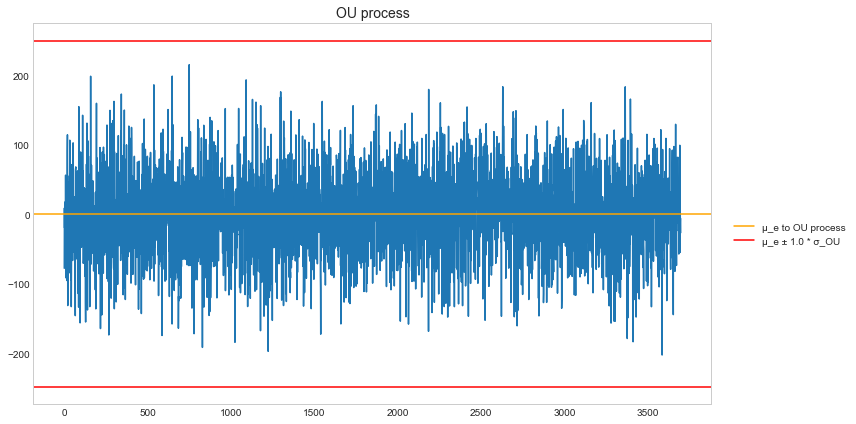

In [28]:
########################################################################
# The function returns σ_eq and σ_eq_AV.                               #
########################################################################
sigma_eq, sigma_eq_AV = pt.pairs_trading_parameters(two_dataframes_train, AR_B, AR_C, AR_ssr, AR_resid, e_t_df)

# Backtesting examples

Here we print some of important results as ADF Test and Engle-Granger procedure second step. It was expalined at pairs_trading_backtest function about graphs, but here we'll get some more details about it. The first graph is a balance by trade graph, not using datetime as horizontal axis. This is important to show because when we use it, as it can be seen at balance by date, drawdown by date and percentage returns by date, it just have periods without any changes in result because the strategy is not in position.

Other important thing to mention is about the stocks graphs. In orange it's plotted their adjusted close prices. For stock that is being estimated there's a blue dotted plotting, which is the estimation values do adjusted close prices. Red and green "blurries" in the back of orange adjusted close prices represents buy and sell positions, respectively.

The vertical lines plotting represents entrys (green) and out points (red).

## Train data

Backtesting example to train data without stop loss using previous calculated parameters.

Residuals are stationary (ADF test).


Number of trades: 3 | Backtest result: 14756.76

Profits: 14756.76 | Losses: 0.00


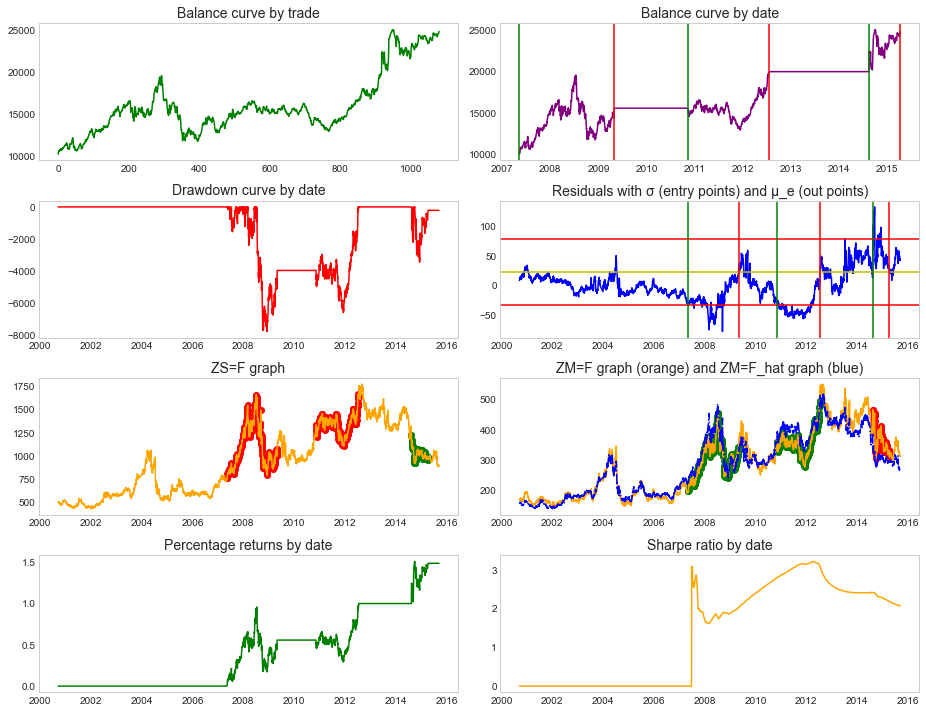

In [29]:
########################################################################
# Backtest example using train dataframe.                              #
########################################################################

# If train data passed at ADF test at bool variable parameters
if adf_train:
    print('Residuals are stationary (ADF test).')
    print()
    
    # If train data passed at Engle-Granger procedure second step
    if e_g_test:
        print('Engle-Granger second step approved both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_train, mu_e, beta_coint, 0.5, sigma_eq, money, 0, False, 0, True)
        
    # If train data not passed at Engle-Granger procedure second step
    else:
        print('WARNING: Engle-Granger second step does not approve both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_train, mu_e, beta_coint, 0.5, sigma_eq, money, 0, False, 0, True)
        
# If train data not passed at ADF test at bool variable parameters
else:
    print('WARNING: residuals are NOT stationary (ADF test).')
    print()
    
    # If train data passed at Engle-Granger procedure second step
    if e_g_test:
        print('Engle-Granger second step approved both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_train, mu_e, beta_coint, 0.5, sigma_eq, money, 0, False, 0, True)
        
    # If train data not passed at Engle-Granger procedure second step
    else:
        print('WARNING: Engle-Granger second step does not approve both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_train, mu_e, beta_coint, 0.5, sigma_eq, money, 0, False, 0, True)

Backtesting example to train data with stop loss using previous calculated parameters.

Residuals are stationary (ADF test).


Number of trades: 3 | Backtest result: 14756.76

Profits: 14756.76 | Losses: 0.00


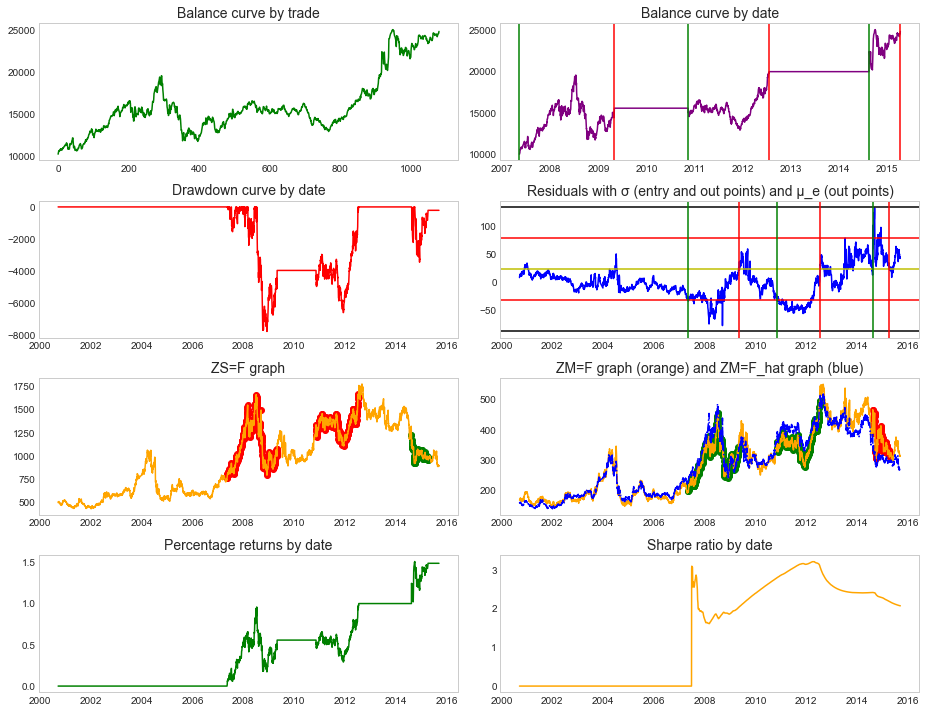

In [30]:
########################################################################
# Backtest example using train dataframe with stop loss.               #
########################################################################

# If train data passed at ADF test at bool variable parameters
if adf_train:
    print('Residuals are stationary (ADF test).')
    print()
    
    # If train data passed at Engle-Granger procedure second step
    if e_g_test:
        print('Engle-Granger second step approved both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_train, mu_e, beta_coint, 0.5, sigma_eq, money, 0, True, 1, True)
        
    # If train data not passed at Engle-Granger procedure second step
    else:
        print('WARNING: Engle-Granger second step does not approve both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_train, mu_e, beta_coint, 0.5, sigma_eq, money, 0, True, 1, True)
        
# If train data not passed at ADF test at bool variable parameters
else:
    print('WARNING: residuals are NOT stationary (ADF test).')
    print()
    
    # If train data passed at Engle-Granger procedure second step
    if e_g_test:
        print('Engle-Granger second step approved both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_train, mu_e, beta_coint, 0.5, sigma_eq, money, 0, True, 1, True)
        
    # If train data not passed at Engle-Granger procedure second step
    else:
        print('WARNING: Engle-Granger second step does not approve both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_train, mu_e, beta_coint, 0.5, sigma_eq, money, 0, True, 1, True)

## Test data

Backtesting example to test data without stop loss using previous calculated parameters.

Residuals are stationary (ADF test).


Number of trades: 3 | Backtest result: 2662.97

Profits: 3429.28 | Losses: -766.30


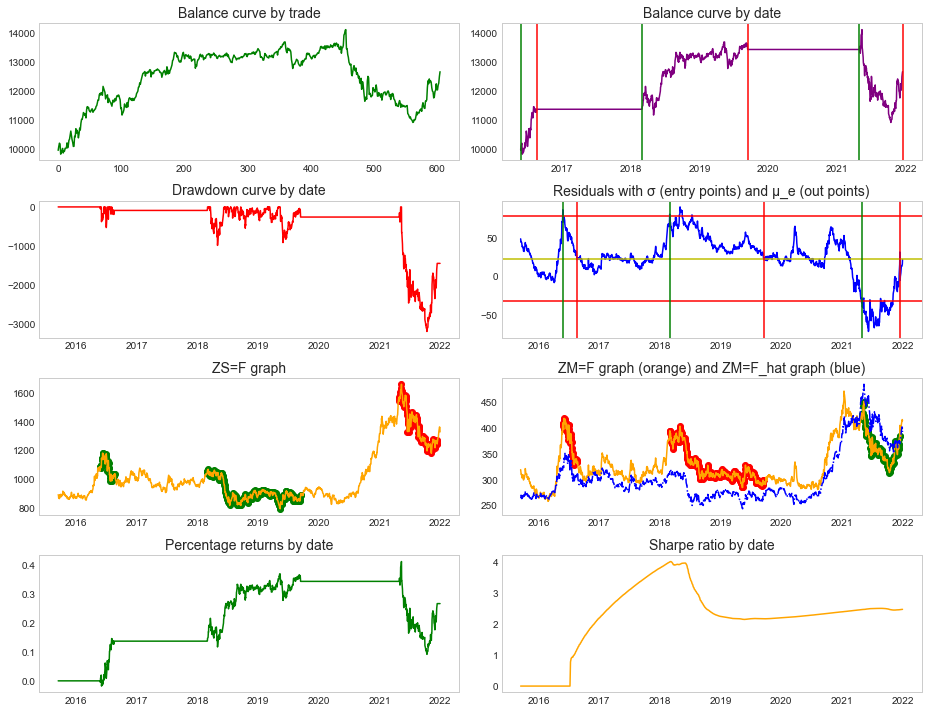

In [31]:
########################################################################
# Backtest example using test dataframe.                               #
########################################################################

# If train data passed at ADF test at bool variable parameters
if adf_train:
    print('Residuals are stationary (ADF test).')
    print()
    
    # If train data passed at Engle-Granger procedure second step
    if e_g_test:
        print('Engle-Granger second step approved both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_test, mu_e, beta_coint, 0.5, sigma_eq, money, 0, False, 0, True)
        
    # If train data not passed at Engle-Granger procedure second step
    else:
        print('WARNING: Engle-Granger second step does not approve both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_test, mu_e, beta_coint, 0.5, sigma_eq, money, 0, False, 0, True)

# If train data not passed at ADF test at bool variable parameters
else:
    print('WARNING: residuals are NOT stationary (ADF test).')
    print()
    
    # If train data passed at Engle-Granger procedure second step
    if e_g_test:
        print('Engle-Granger second step approved both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_test, mu_e, beta_coint, 0.5, sigma_eq, money, 0, False, 0, True)
        
    # If train data not passed at Engle-Granger procedure second step
    else:
        print('WARNING: Engle-Granger second step does not approve both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_test, mu_e, beta_coint, 0.5, sigma_eq, money, 0, False, 0, True)

Backtesting example to test data with stop loss using previous calculated parameters.

Residuals are stationary (ADF test).


Number of trades: 3 | Backtest result: 2662.97

Profits: 3429.28 | Losses: -766.30


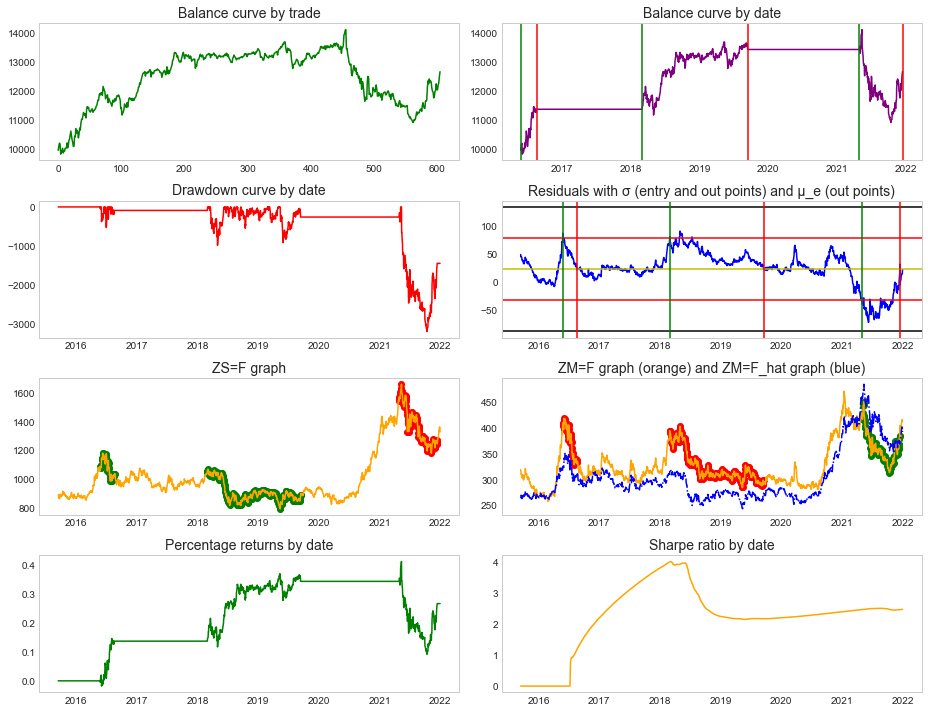

In [32]:
########################################################################
# Backtest example using test dataframe with stop loss.                #
########################################################################

# If train data passed at ADF test at bool variable parameters
if adf_train:
    print('Residuals are stationary (ADF test).')
    print()
    
    # If train data passed at Engle-Granger procedure second step
    if e_g_test:
        print('Engle-Granger second step approved both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_test, mu_e, beta_coint, 0.5, sigma_eq, money, 0, True, 1, True)
        
    # If train data not passed at Engle-Granger procedure second step
    else:
        print('WARNING: Engle-Granger second step does not approve both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_test, mu_e, beta_coint, 0.5, sigma_eq, money, 0, True, 1, True)
        
# If train data passed at ADF test at bool variable parameters
else:
    print('WARNING: residuals are NOT stationary (ADF test).')
    print()
    
    # If train data passed at Engle-Granger procedure second step
    if e_g_test:
        print('Engle-Granger second step approved both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_test, mu_e, beta_coint, 0.5, sigma_eq, money, 0, True, 1, True)
        
    # If train data not passed at Engle-Granger procedure second step
    else:
        print('WARNING: Engle-Granger second step does not approve both coefficient and constant to model.')
        print()
        pt.pairs_trading_backtest(two_dataframes_test, mu_e, beta_coint, 0.5, sigma_eq, money, 0, True, 1, True)

# Strategy design

Strategy design involves optimization and some _'human criteria'_ about results. We need to avoid overfitting and underfitting. Overfitting occurs when we optimize so much our model, that it turns perfect - to past data, and has horrible results when deploying it. Underfitting is based on simplify so much your model that it doesn't have good results to show even in train data sometimes.

Way to have good results is to not have so much degrees of freedom and have not visualized data by model to test it. In this working code it is used 70% of data to train the model and 30% to test it. First good point to the model is when result is positive at test data. Other good stuff to analyze is about worst drawdown, maintenance of percentage results and smoothed curve of balance.

## Optimizing Z for each σ

It is not necessary, but we'll optimize both $σ_{eq}$ and $σ_{eq_{AV}}$ to compare results. Optimization will validate sensitivities and will take some time to show results when running code because it is programmed to run by 0.001 value to $σ_{eq}$ and by 0.005 to $σ_{eq_{AV}}$.

A notorious result is the exponencial decrease of the number of trades when entry Z assumes bigger values.

## Entry points parameters

### $Z_{opt}$ applied to $σ_{eq}$

Best return is 114915.84 with Z of 0.243


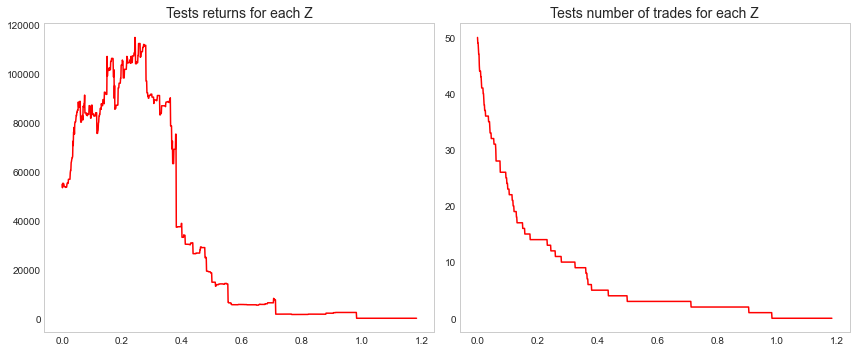

In [33]:
########################################################################
# Optimizing train dataframe for the best return on Z. The function    #
# returns a dataframe with all tests results, the best return and Z    #
# that gives the best return.                                          #
########################################################################
optimize_df_train_eq, best_return_eq, best_z_eq = pt.optimize_pairs_z(two_dataframes_train, mu_e, beta_coint, sigma_eq, 0.001, money)

Number of trades: 13 | Backtest result: 114915.84

Profits: 114915.84 | Losses: 0.00


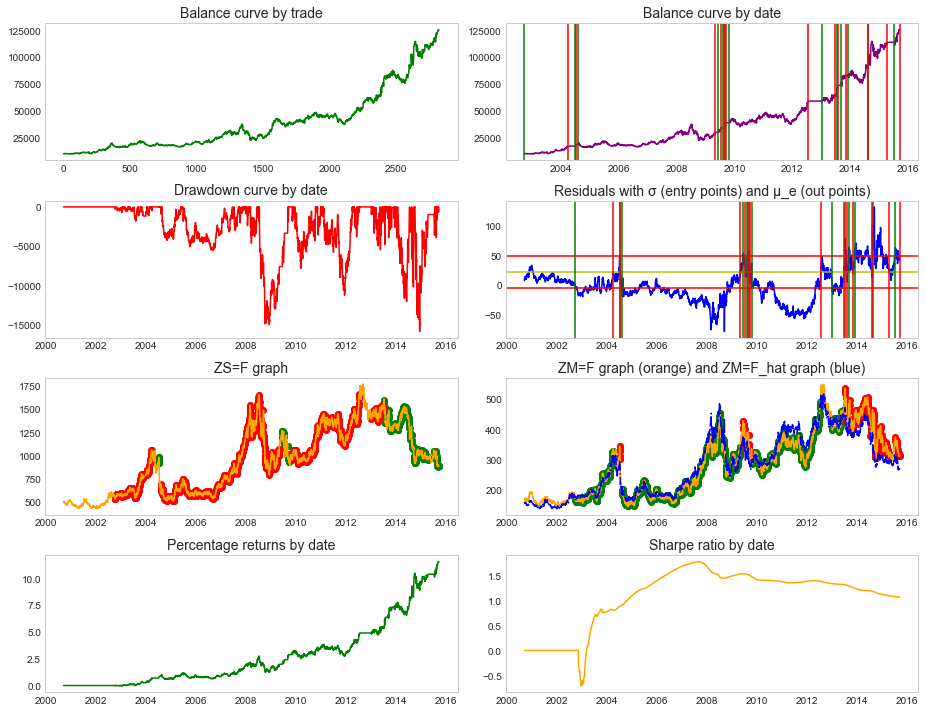

In [34]:
########################################################################
# Backtest train with best Z.                                          #
########################################################################
num_eq_train, ret_eq_train, none_var1, none_var2, none_var3 = pt.pairs_trading_backtest(two_dataframes_train, mu_e, beta_coint, 
                                                    best_z_eq, sigma_eq, money, 0, False, 0, True)

Number of trades: 7 | Backtest result: 3900.30

Profits: 5923.64 | Losses: -2023.34


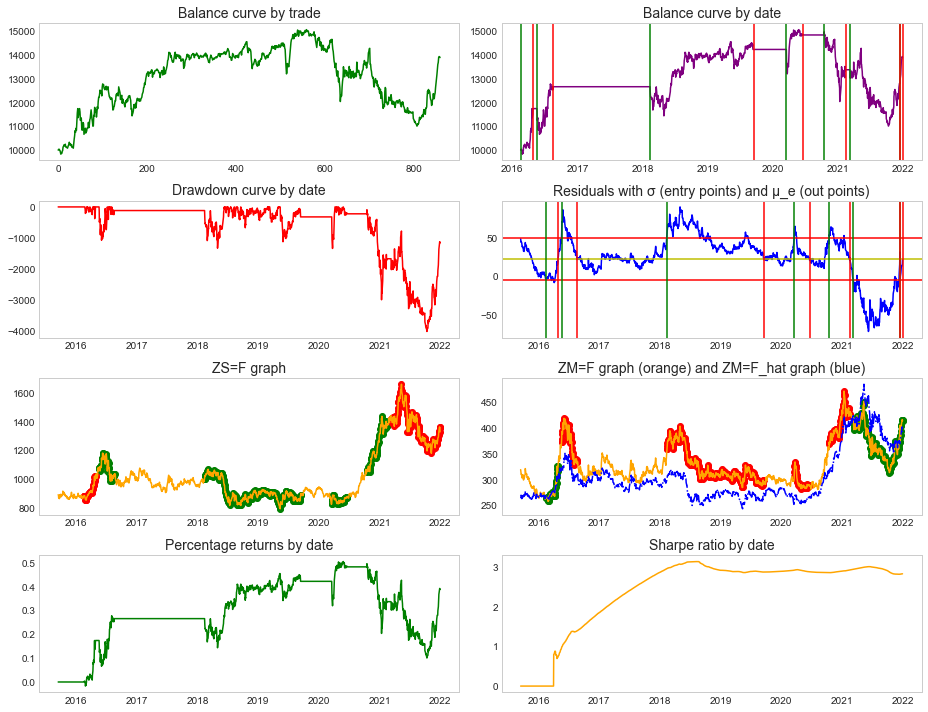

In [35]:
########################################################################
# Backtest test with best Z.                                           #
########################################################################
num_eq_test, ret_eq_test, none_var1, none_var2, none_var3 = pt.pairs_trading_backtest(two_dataframes_test, mu_e, beta_coint, 
                                                  best_z_eq, sigma_eq, money, 0, False, 0, True)

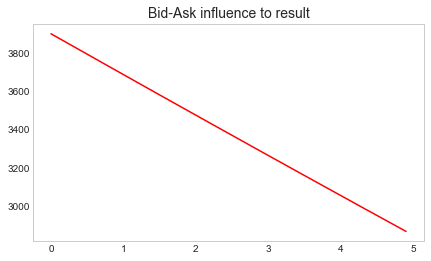

In [36]:
########################################################################
# Bid-ask influence to result.                                         #
########################################################################
b_a_eq = pt.bid_ask_influence(0, 5, 0.1, two_dataframes_test, mu_e, beta_coint, best_z_eq, sigma_eq, money)

In [37]:
########################################################################
# Dataframe head to show results.                                      #
########################################################################
b_a_eq.head()

Bid-Ask spread  Number of trades       Result
0             0.0                 7  3900.297981
1             0.1                 7  3878.951275
2             0.2                 7  3857.543371
3             0.3                 7  3836.135599
4             0.4                 7  3814.789861

### $Z_{opt}$ applied to $σ_{eq_{AV}}$

Best return is 114915.84 with Z of 6.64


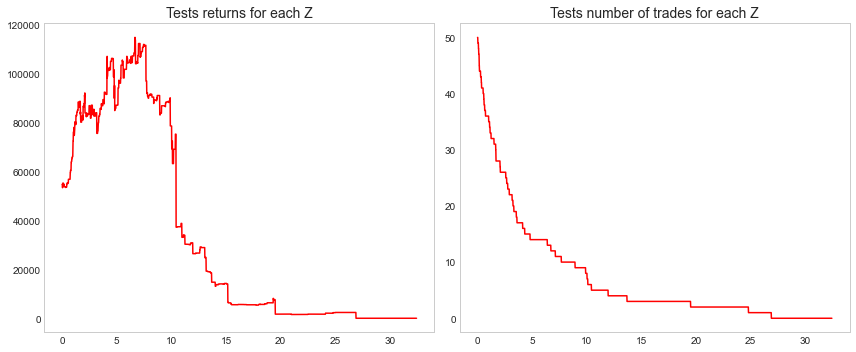

In [38]:
########################################################################
# Optimizing train dataframe for the best return on Z. The function    #
# returns a dataframe with all tests results, the best return and Z    #
# that gives the best return.                                          #
########################################################################
optimize_df_train_eq_AV, best_return_eq_AV, best_z_eq_AV = pt.optimize_pairs_z(two_dataframes_train, mu_e, beta_coint, sigma_eq_AV, 0.005, money)

Number of trades: 13 | Backtest result: 114915.84

Profits: 114915.84 | Losses: 0.00


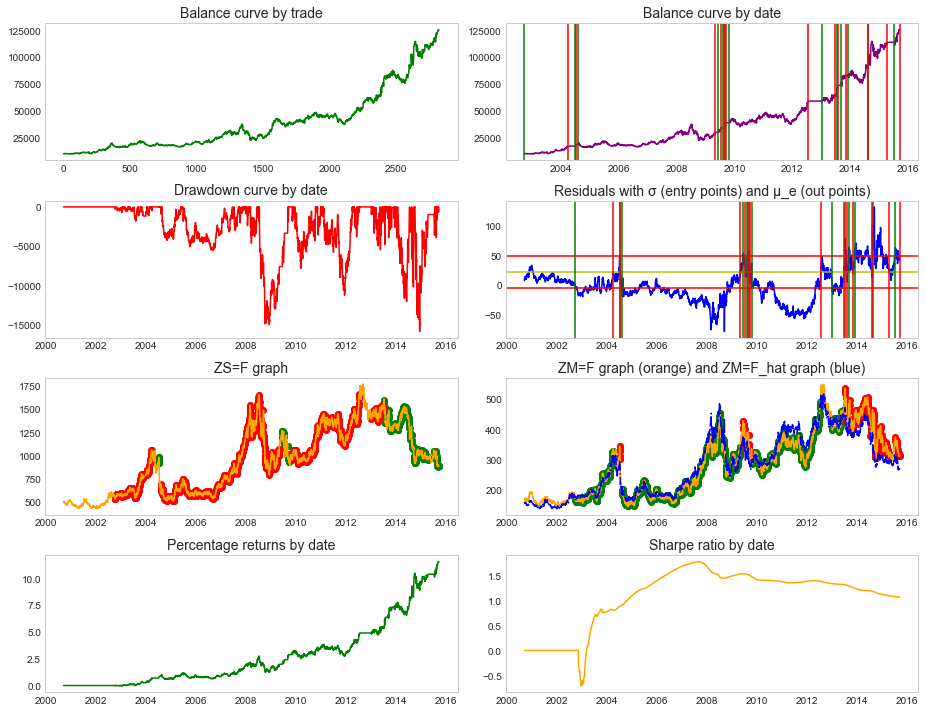

In [39]:
########################################################################
# Backtest train with best Z.                                          #
########################################################################
num_eq_AV_train, ret_eq_AV_train, none_var1, none_var2, none_var3 = pt.pairs_trading_backtest(two_dataframes_train, mu_e, beta_coint, 
                                                          best_z_eq_AV, sigma_eq_AV, money, 0, False, 0, True)

Number of trades: 7 | Backtest result: 3900.30

Profits: 5923.64 | Losses: -2023.34


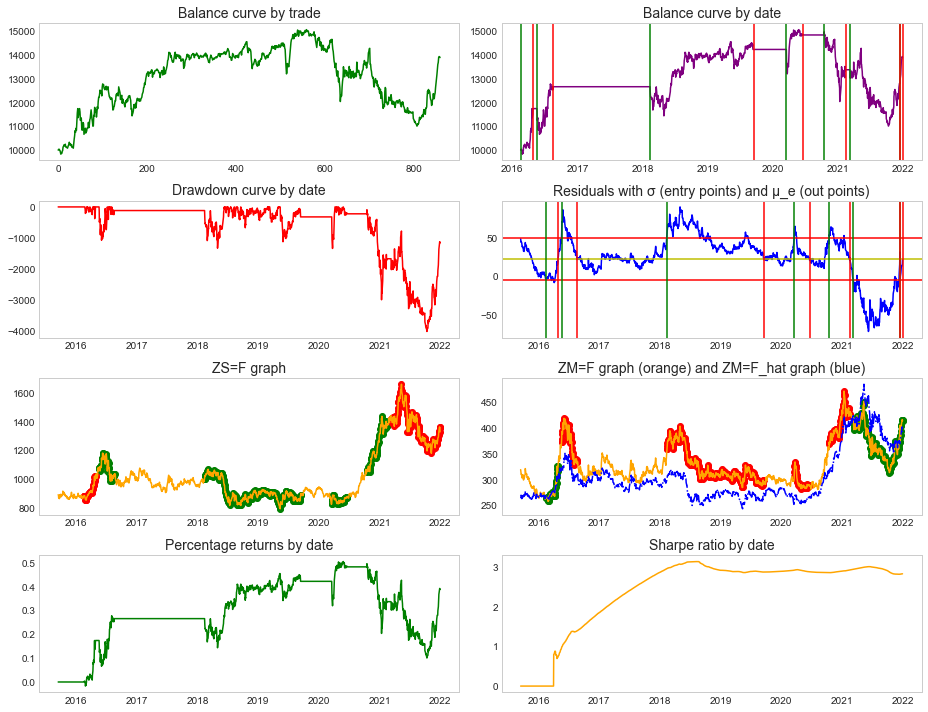

In [40]:
########################################################################
# Backtest test with best Z.                                           #
########################################################################
num_eq_AV_test, ret_eq_AV_test, none_var1, none_var2, none_var3 = pt.pairs_trading_backtest(two_dataframes_test, mu_e, beta_coint, 
                                                        best_z_eq_AV, sigma_eq_AV, money, 0, False, 0, True)

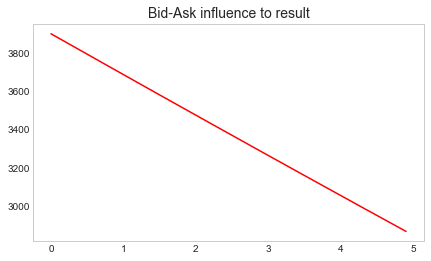

In [41]:
########################################################################
# Bid-ask influence to result plot.                                    #
########################################################################
b_a_eq_AV = pt.bid_ask_influence(0, 5, 0.1, two_dataframes_test, mu_e, beta_coint, best_z_eq_AV, sigma_eq_AV, money)

In [42]:
########################################################################
# Dataframe head to show results.                                      #
########################################################################
b_a_eq_AV.head()

Bid-Ask spread  Number of trades       Result
0             0.0                 7  3900.297981
1             0.1                 7  3878.951275
2             0.2                 7  3857.543371
3             0.3                 7  3836.135599
4             0.4                 7  3814.789861

## $Z_{opt}$ results

In [43]:
########################################################################
# Dataframe with all results of optimization.                          #
########################################################################

# Percentage returns
perc_eq_train = '{0:,.2f}'.format(ret_eq_train * 100 / money)
perc_eq_AV_train = '{0:,.2f}'.format(ret_eq_AV_train * 100 / money)
perc_eq_test = '{0:,.2f}'.format(ret_eq_test * 100 / money)
perc_eq_AV_test = '{0:,.2f}'.format(ret_eq_AV_test * 100 / money)

# Z multiplied by σ
mult_eq = '{0:,.4f}'.format(sigma_eq * best_z_eq)
mult_eq_AV = '{0:,.4f}'.format(sigma_eq_AV * best_z_eq_AV)

# List with all results
all_results_list = [[sigma_eq, best_z_eq, mult_eq, num_eq_train, ret_eq_train, perc_eq_train, num_eq_test, ret_eq_test, perc_eq_test], 
          [sigma_eq_AV, best_z_eq_AV, mult_eq_AV, num_eq_AV_train, ret_eq_AV_train, perc_eq_AV_train, num_eq_AV_test, ret_eq_AV_test, perc_eq_AV_test]]

# List to dataframe
all_results_df = pd.DataFrame(all_results_list)
all_results_df.columns = ['σ value', 'Best Z', '± Z * σ', 'Train trades', 'Train return', 'Train % return', 
                          'Test trades', 'Test return', 'Test % return']
all_results_df.index = ['σ_eq', 'σ_eq_AV']

## Stop loss parameters

### $Z_{opt_{Stop Loss}}$ applied to $σ_{eq}$

Best return is 134088.69 with Z to stop loss of 0.797


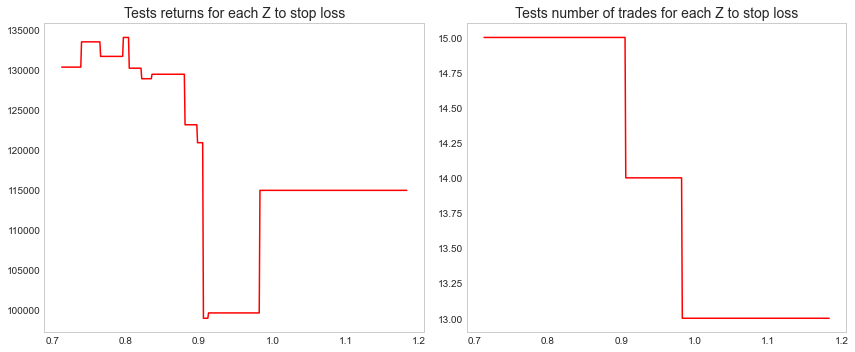

In [44]:
########################################################################
# Optimizing train dataframe for the best return on Z to stop loss.    #
# The function returns a dataframe with all tests results, the best    #
# return and Z that gives the best return.                             #
########################################################################
optimize_stop_loss_df_train_eq, best_return_stop_loss_eq, best_z_stop_loss_eq = pt.optimize_pairs_stop_loss_z(two_dataframes_train, mu_e, beta_coint, 
                                                                                                sigma_eq, best_z_eq, 0.001, money)

Number of trades: 15 | Backtest result: 134088.69

Profits: 134088.69 | Losses: 0.00


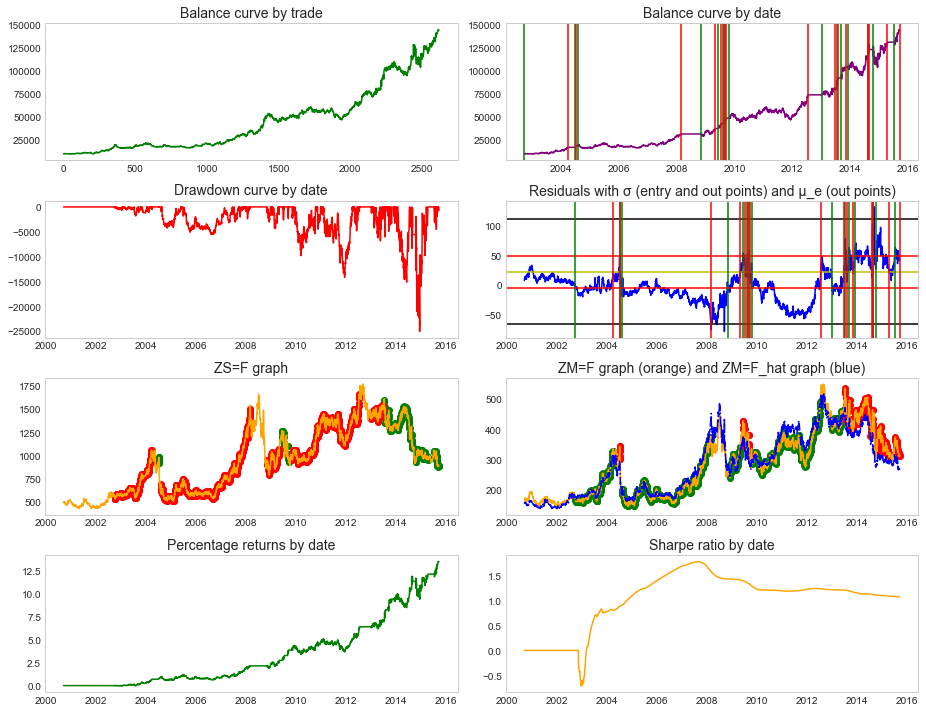

In [45]:
########################################################################
# Backtest train with best Z stop loss and best entry Z.               #
########################################################################
num_eq_train_SL, ret_eq_train_SL, none_var1, none_var2, none_var3 = pt.pairs_trading_backtest(two_dataframes_train, mu_e, beta_coint, 
                                                                                      best_z_eq, sigma_eq, money, 
                                                                                      0, True, best_z_stop_loss_eq, True)

Number of trades: 8 | Backtest result: 4352.66

Profits: 6357.27 | Losses: -2004.61


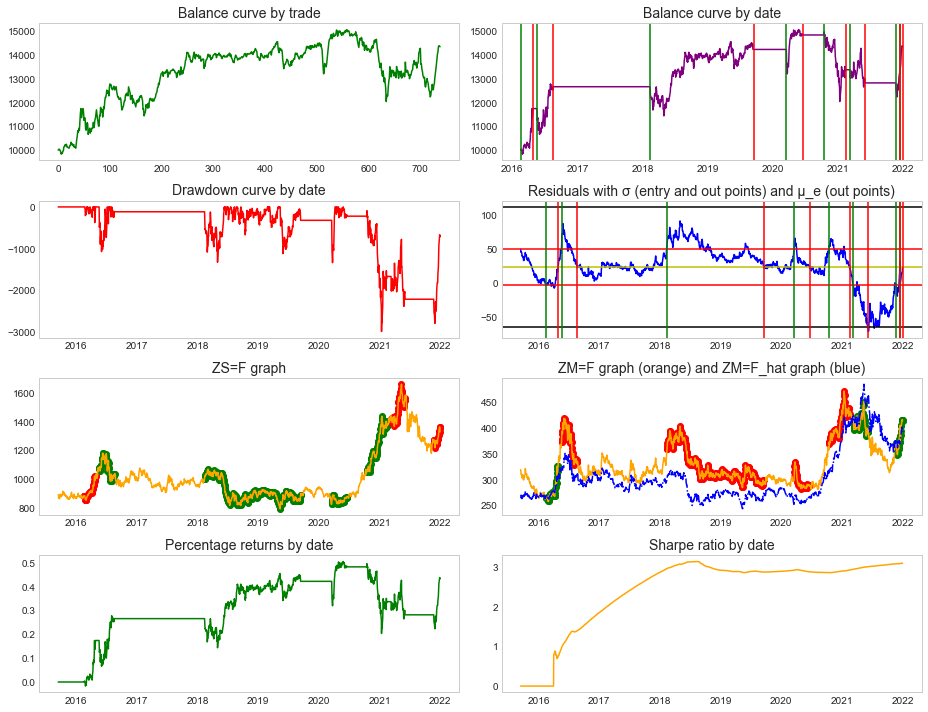

In [46]:
########################################################################
# Backtest test with best Z stop loss and best entry Z.                #
########################################################################
num_eq_test_SL, ret_eq_test_SL, none_var1, none_var2, none_var3 = pt.pairs_trading_backtest(two_dataframes_test, mu_e, beta_coint, 
                                                                              best_z_eq, sigma_eq, money, 
                                                                              0, True, best_z_stop_loss_eq, True)

### $Z_{opt_{Stop Loss}}$ applied to $σ_{eq_{AV}}$

Best return is 134088.69 with Z to stop loss of 21.791


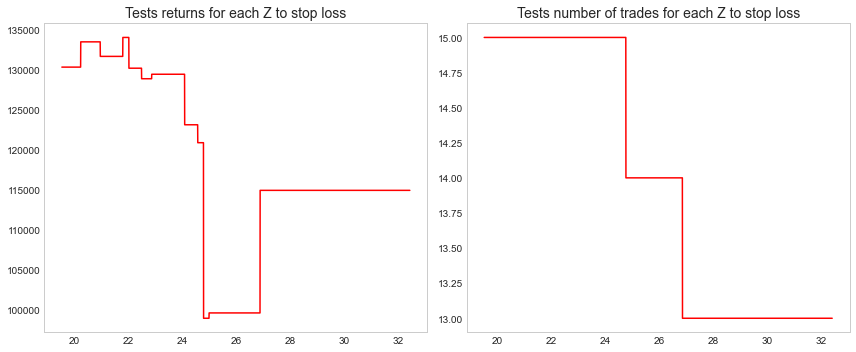

In [47]:
########################################################################
# Optimizing train dataframe for the best return on Z to stop loss.    #
# The function returns a dataframe with all tests results, the best    #
# return and Z that gives the best return.                             #
########################################################################
optimize_stop_loss_df_train_eq_AV, best_return_stop_loss_eq_AV, best_z_stop_loss_eq_AV = pt.optimize_pairs_stop_loss_z(two_dataframes_train, mu_e, beta_coint, 
                                                                                                sigma_eq_AV, best_z_eq_AV, 0.005, money)

Number of trades: 15 | Backtest result: 134088.69

Profits: 134088.69 | Losses: 0.00


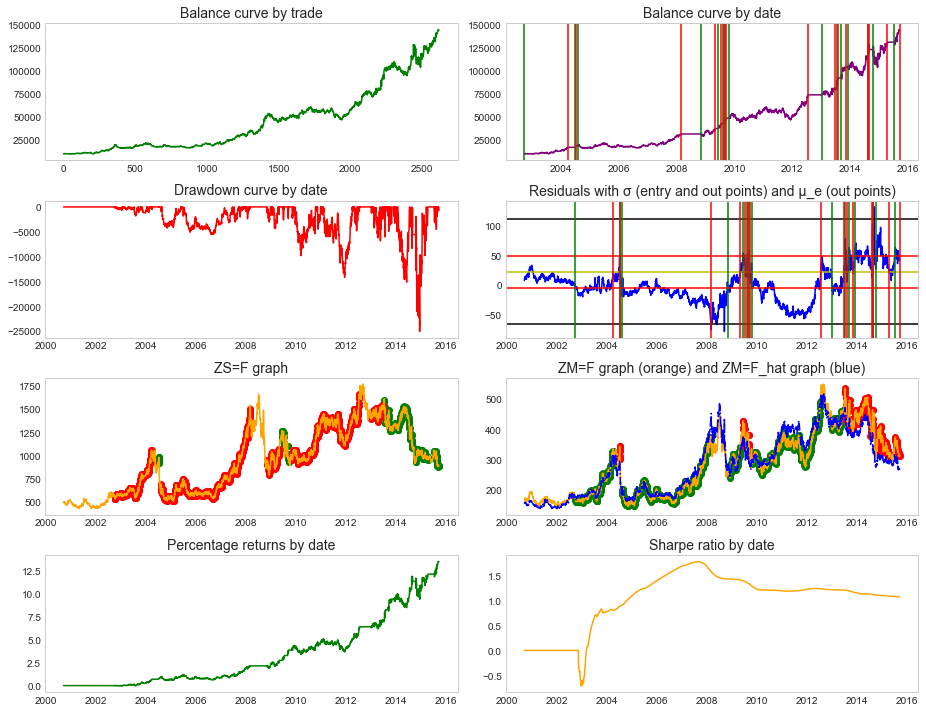

In [48]:
########################################################################
# Backtest train with best Z stop loss and best entry Z.               #
########################################################################
num_eq_AV_train_SL, ret_eq_AV_train_SL, none_var1, none_var2, none_var3 = pt.pairs_trading_backtest(two_dataframes_train, mu_e, beta_coint, 
                                                                                      best_z_eq_AV, sigma_eq_AV, money, 
                                                                                      0, True, best_z_stop_loss_eq_AV, True)

Number of trades: 8 | Backtest result: 4352.66

Profits: 6357.27 | Losses: -2004.61


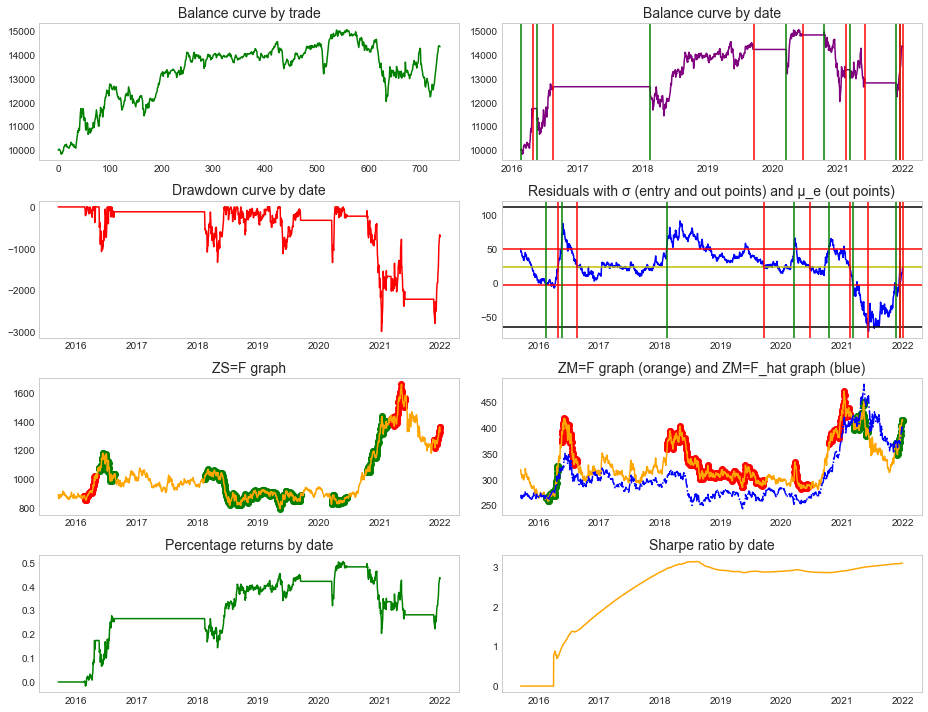

In [49]:
########################################################################
# Backtest test with best Z stop loss and best entry Z.                #
########################################################################
num_eq_AV_test_SL, ret_eq_AV_test_SL, none_var1, none_var2, none_var3 = pt.pairs_trading_backtest(two_dataframes_test, mu_e, beta_coint, 
                                                                                    best_z_eq_AV, sigma_eq_AV, money, 
                                                                                    0, True, best_z_stop_loss_eq_AV, True)

## $Z_{opt_{Stop Loss}}$ results

In [50]:
########################################################################
# Dataframe with all results of optimization.                          #
########################################################################

# Percentage returns
perc_eq_train_SL = '{0:,.2f}'.format(ret_eq_train_SL * 100 / money)
perc_eq_AV_train_SL = '{0:,.2f}'.format(ret_eq_AV_train_SL * 100 / money)
perc_eq_test_SL = '{0:,.2f}'.format(ret_eq_test_SL * 100 / money)
perc_eq_AV_test_SL = '{0:,.2f}'.format(ret_eq_AV_test_SL * 100 / money)

# Z multiplied by σ
mult_eq = '{0:,.4f}'.format(sigma_eq * best_z_eq)
mult_eq_AV = '{0:,.4f}'.format(sigma_eq_AV * best_z_eq_AV)

# Z stop loss multiplied by σ
mult_eq_SL = '{0:,.4f}'.format(sigma_eq * best_z_stop_loss_eq)
mult_eq_AV_SL = '{0:,.4f}'.format(sigma_eq_AV * best_z_stop_loss_eq_AV)

# List with all results
all_results_SL_list = [[sigma_eq, best_z_eq, mult_eq, best_z_stop_loss_eq, mult_eq_SL, 
                        num_eq_train_SL, ret_eq_train_SL, perc_eq_train_SL, num_eq_test_SL, 
                        ret_eq_test_SL, perc_eq_test_SL], 
                       [sigma_eq_AV, best_z_eq_AV, mult_eq_AV, best_z_stop_loss_eq_AV, mult_eq_AV_SL, 
                        num_eq_AV_train_SL, ret_eq_AV_train_SL, perc_eq_AV_train_SL, num_eq_AV_test_SL, 
                        ret_eq_AV_test_SL, perc_eq_AV_test_SL]]

# List to dataframe
all_results_df_SL = pd.DataFrame(all_results_SL_list)
all_results_df_SL.columns = ['σ value', 'Best Z', '± Z * σ', 'Best Z_SL', '± Z_SL * σ', 
                             'Train trades', 'Train return', 'Train % return', 'Test trades', 
                             'Test return', 'Test % return']
all_results_df_SL.index = ['σ_eq', 'σ_eq_AV']

### Results without Stop Loss

In [51]:
# Results visualization without stop loss
all_results_df

σ value  Best Z  ± Z * σ  Train trades   Train return  \
σ_eq     111.112880   0.243  27.0004            13  114915.840837   
σ_eq_AV    4.060714   6.640  26.9631            13  114915.840837   

        Train % return  Test trades  Test return Test % return  
σ_eq          1,149.16            7  3900.297981         39.00  
σ_eq_AV       1,149.16            7  3900.297981         39.00

### Results with Stop Loss

In [52]:
# Results visualization with stop loss
all_results_df_SL

σ value  Best Z  ± Z * σ  Best Z_SL ± Z_SL * σ  Train trades  \
σ_eq     111.112880   0.243  27.0004      0.797    88.5570            15   
σ_eq_AV    4.060714   6.640  26.9631     21.791    88.4870            15   

          Train return Train % return  Test trades  Test return Test % return  
σ_eq     134088.685419       1,340.89            8  4352.664208         43.53  
σ_eq_AV  134088.685419       1,340.89            8  4352.664208         43.53

# Conclusions

As it can be seen, cointegration analisys results had very good results at train data and had a less, but positive, result to test data. Another good result was using stop loss Z, that produced a bigger result when comparing withou stop loss Z. A future implementation can be a money to trade based on stop loss size to improve risk management. To conclude, we use Quantopian methods to backtest our trading strategy.

# Best results backtest - Quantopian

## Train data

### $σ_{eq}$

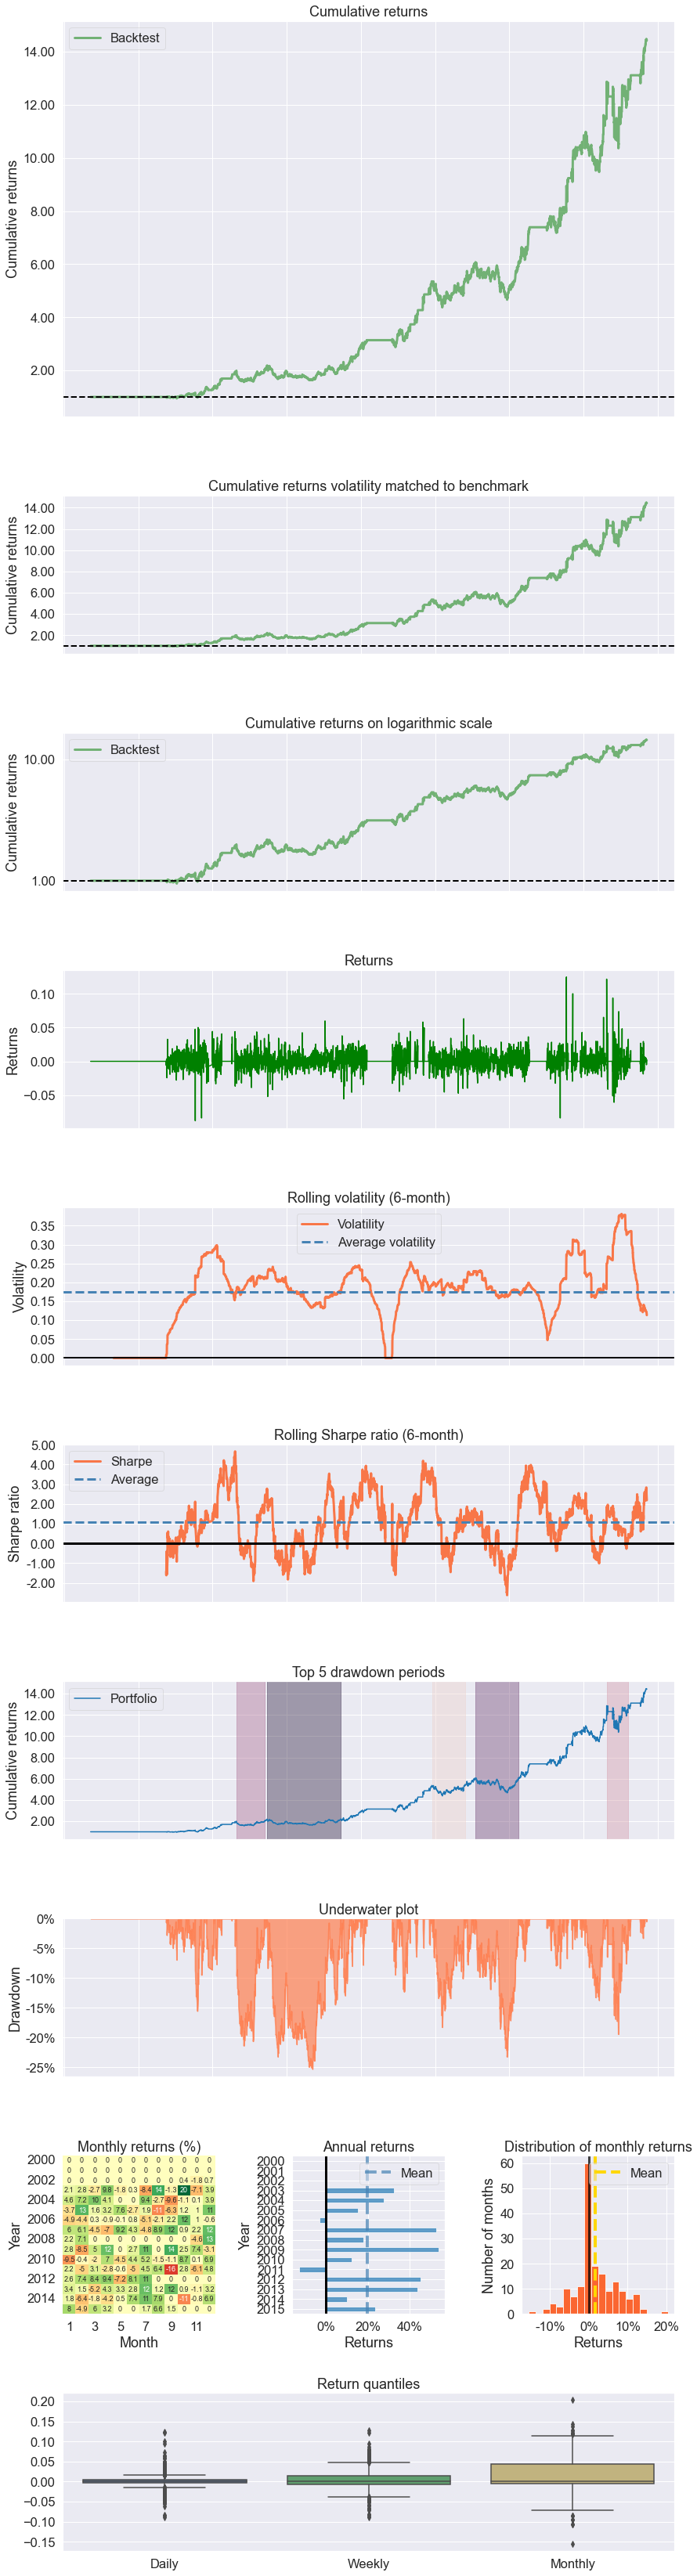

In [53]:
percentage_returns_eq_train = pt.pairs_trading_backtest(two_dataframes_train, mu_e, beta_coint, best_z_eq, sigma_eq, money, 
                                            0, True, best_z_stop_loss_eq, False)

pf.create_returns_tear_sheet(percentage_returns_eq_train[4].dropna().squeeze())

### $σ_{eq_{AV}}$

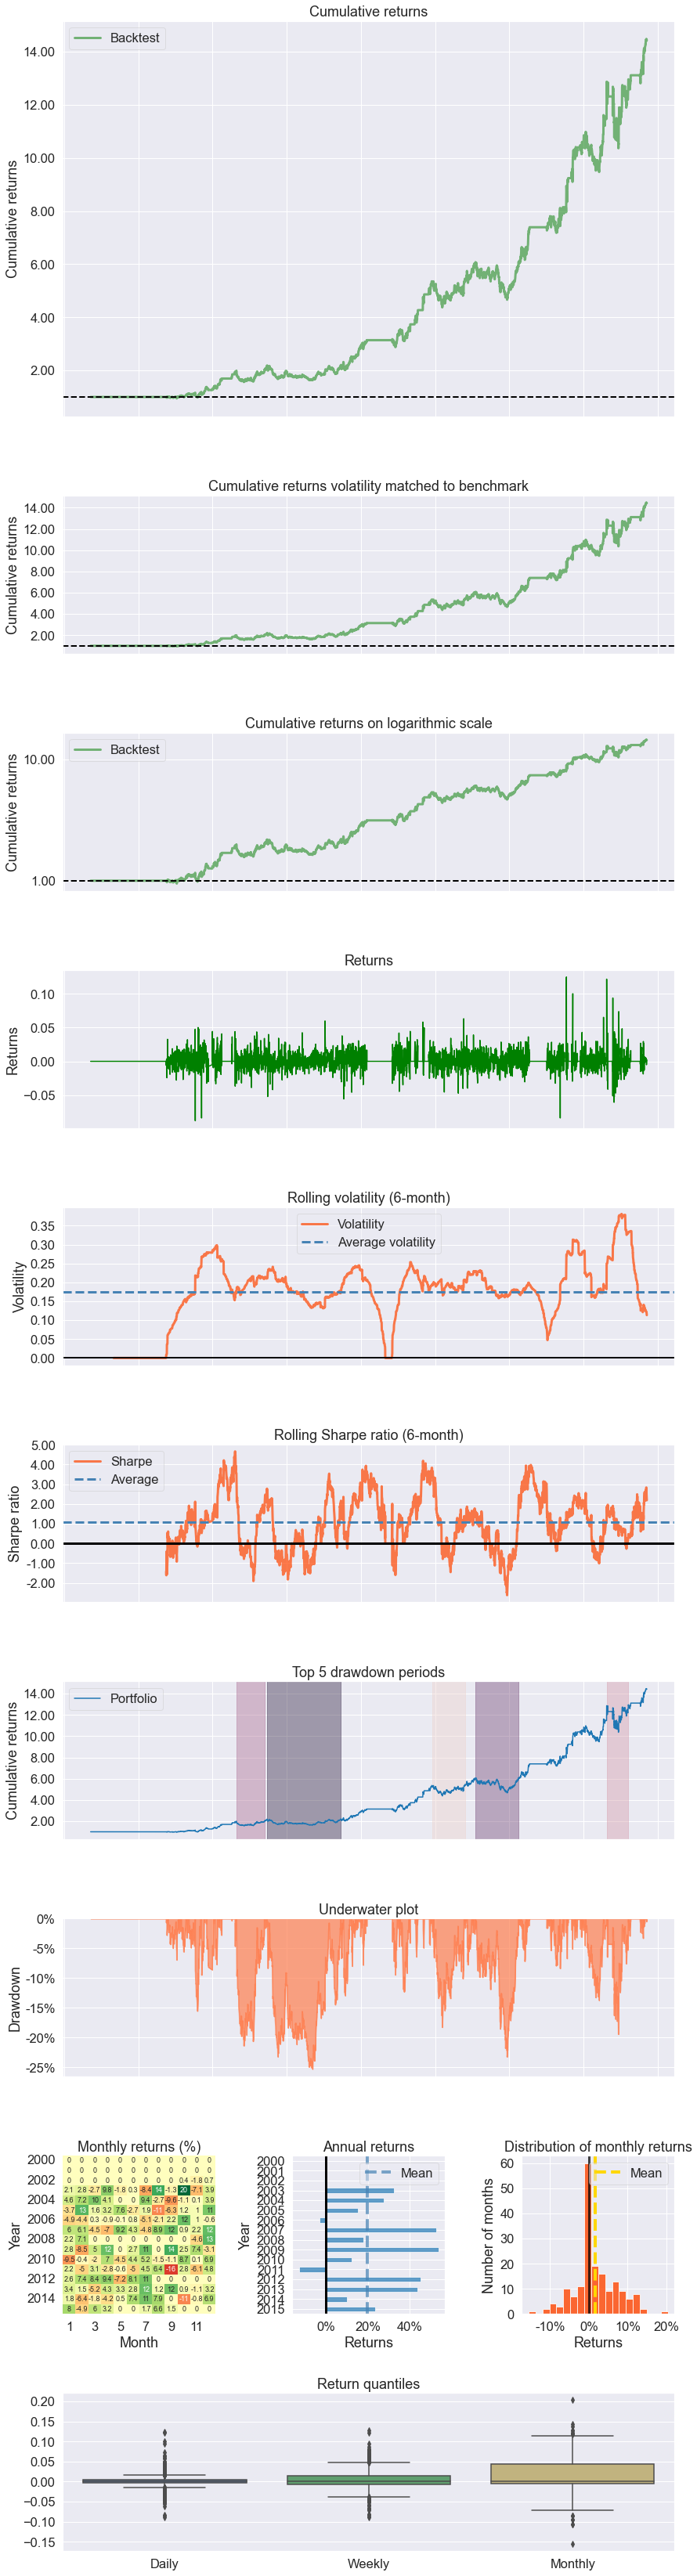

In [54]:
percentage_returns_eq_AV_train = pt.pairs_trading_backtest(two_dataframes_train, mu_e, beta_coint, best_z_eq_AV, sigma_eq_AV, money, 
                                            0, True, best_z_stop_loss_eq_AV, False)

pf.create_returns_tear_sheet(percentage_returns_eq_AV_train[4].dropna().squeeze())

## Test data

### $σ_{eq}$

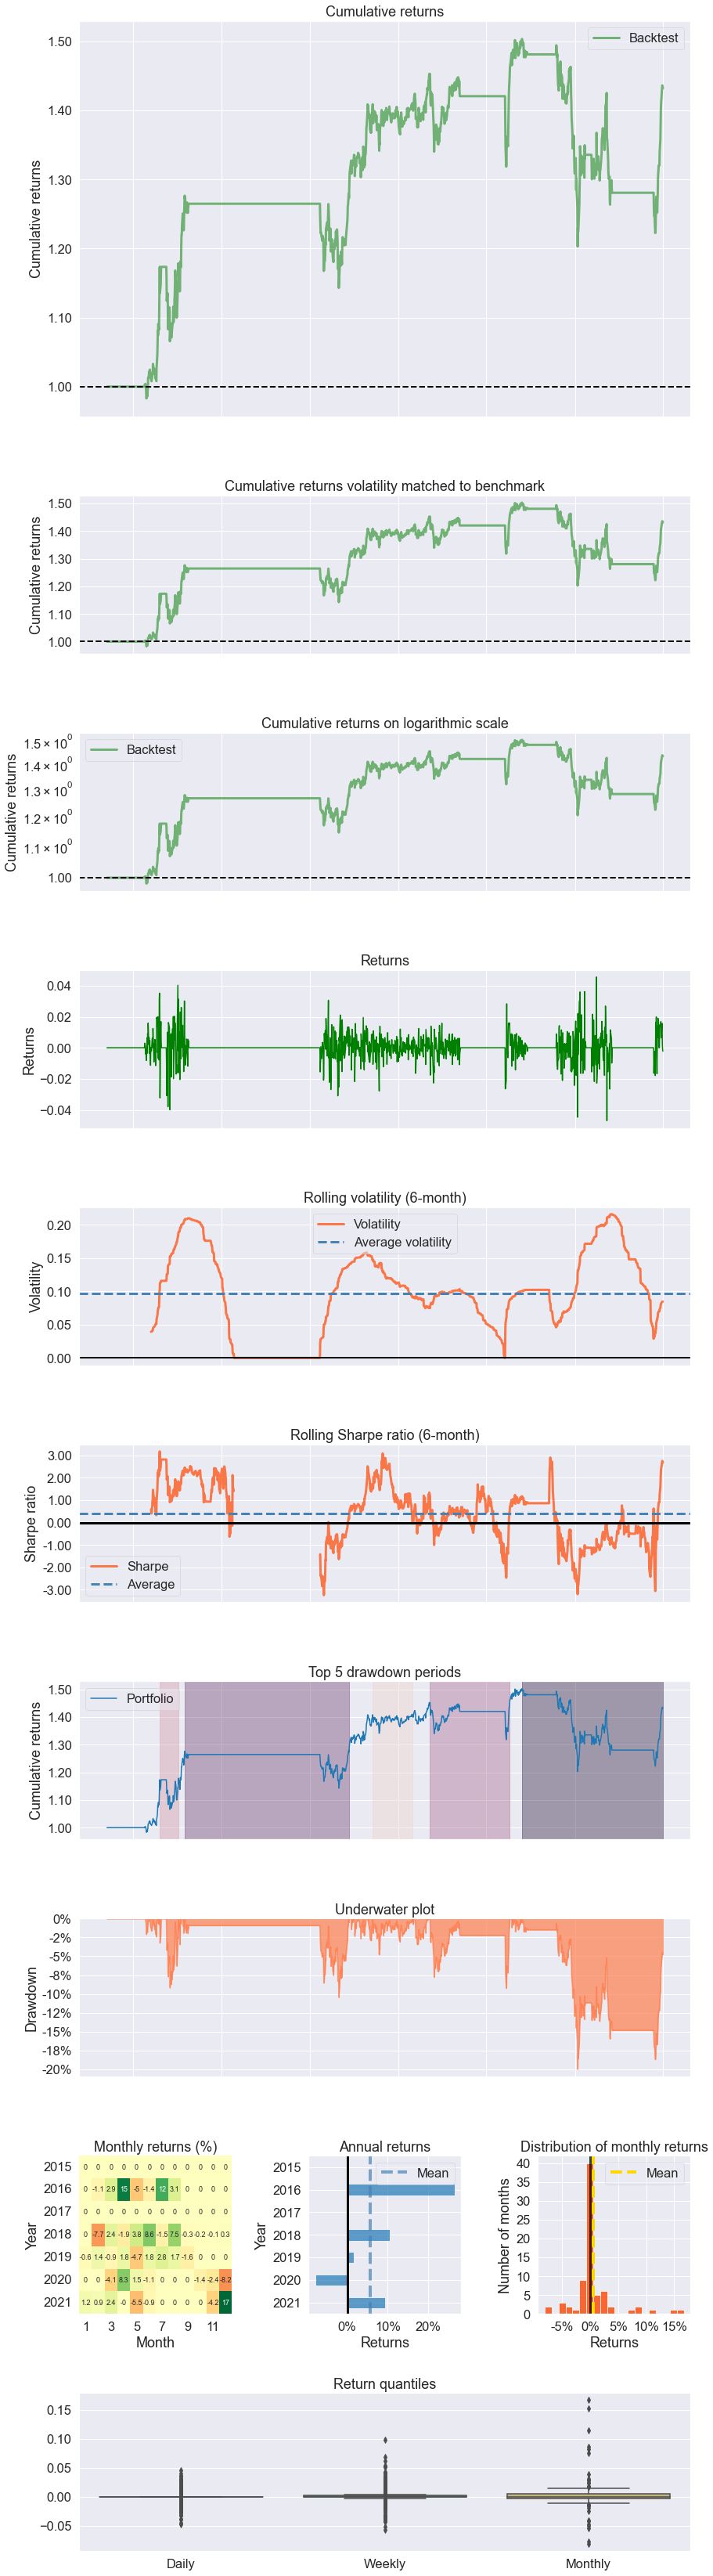

In [55]:
percentage_returns_eq_test = pt.pairs_trading_backtest(two_dataframes_test, mu_e, beta_coint, best_z_eq, sigma_eq, money, 
                                            0, True, best_z_stop_loss_eq, False)

pf.create_returns_tear_sheet(percentage_returns_eq_test[4].dropna().squeeze())

### $σ_{eq_{AV}}$

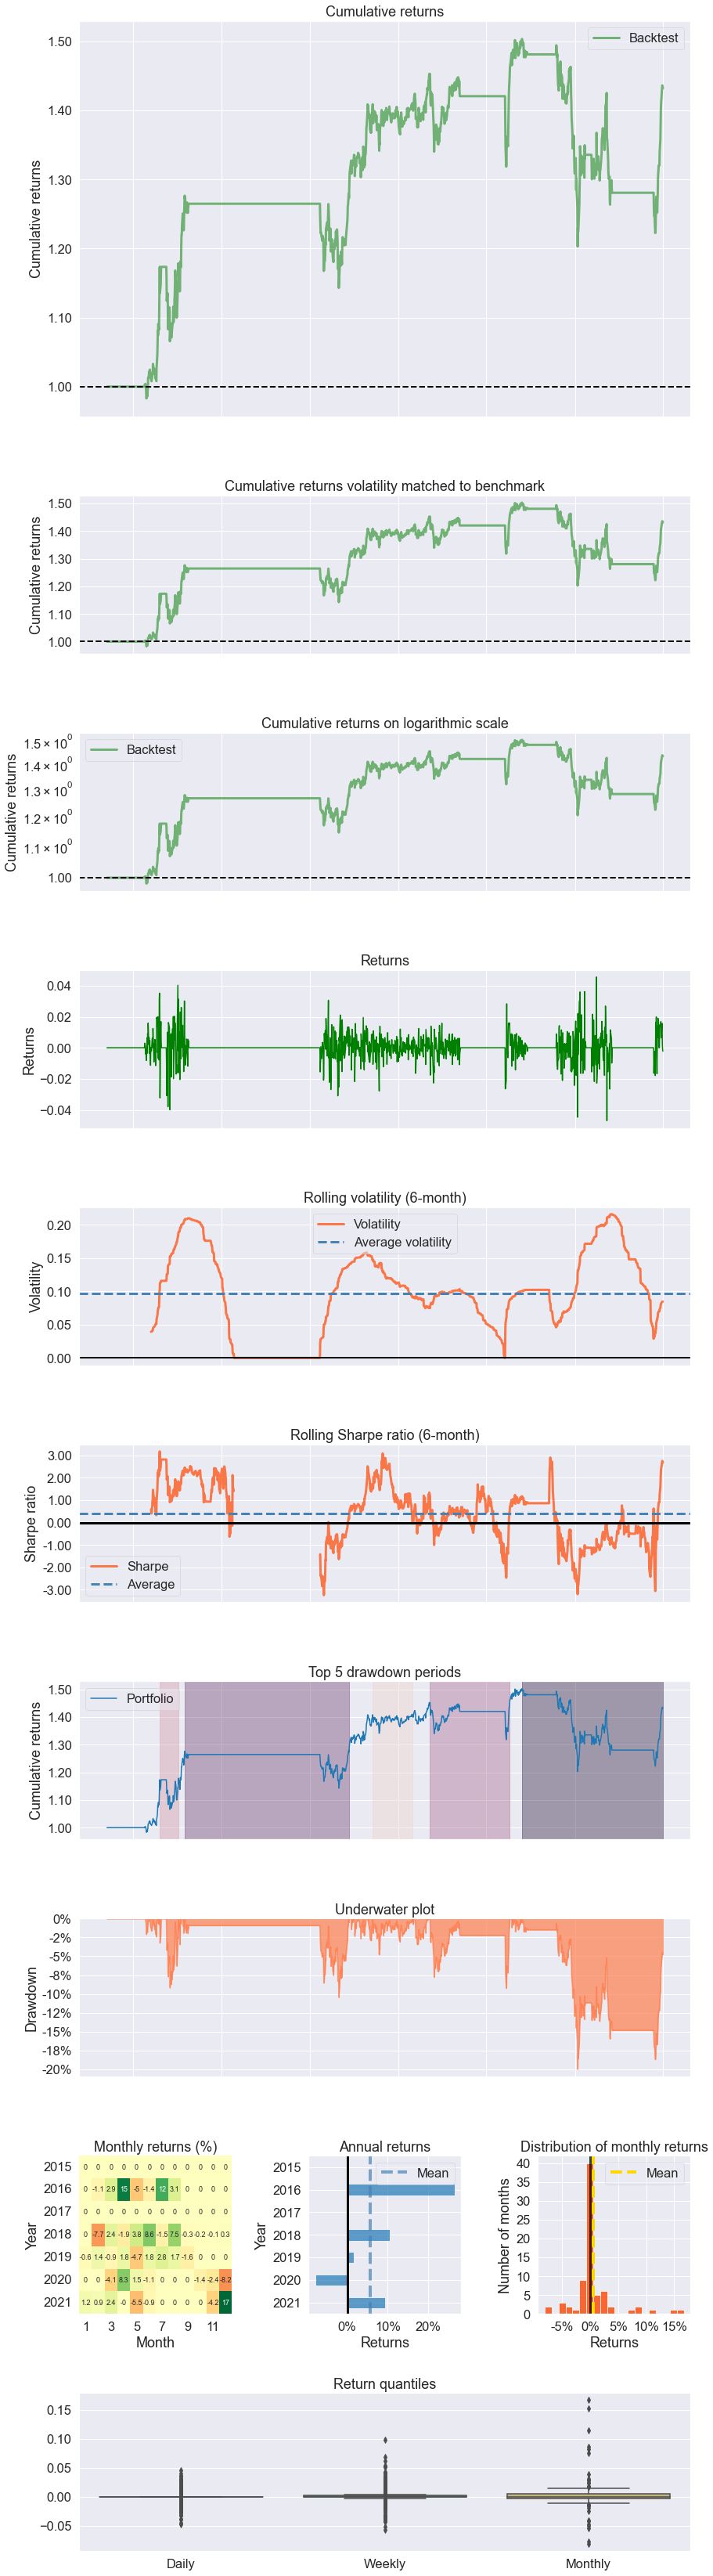

In [56]:
percentage_returns_eq_AV_test = pt.pairs_trading_backtest(two_dataframes_test, mu_e, beta_coint, best_z_eq_AV, sigma_eq_AV, money, 
                                            0, True, best_z_stop_loss_eq_AV, False)

pf.create_returns_tear_sheet(percentage_returns_eq_AV_test[4].dropna().squeeze())

# References

- Augmented Dickey-Fuller test. (2021). Retrieved December, 21, 2021 from https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test/.

- Cointegration. (2021). Retrieved December, 14, 2021 from https://en.wikipedia.org/wiki/Cointegration/.

- CQF Program. Advanced Electives, Elective 1 – Algorithmic Trading.

- CQF Program. Advanced Electives, Elective 3 – Advanced Risk Management.

- CQF Program. Module 6, Lecture 12 – Final Project Workshop I.

- CQF Program. Module 6, Lecture 15 – Final Project Workshop II.

- CQF Program. Module 6, Lecture 8 – Co-Integration for Trading.

- CQF Program. Python labs – Introduction to Financial Time Series.

- CQF Program. Tutorials – Final Project Tutorial I.

- CQF Program. Tutorials – Final Project Tutorial II.

- CQF Program. Tutorials – Final Project Tutorial III.

- Diamond, Richard V., Learning and Trusting Cointegration in Statistical Arbitrage (September 30, 2014). Available at SSRN: https://ssrn.com/abstract=2220092 or http://dx.doi.org/10.2139/ssrn.2220092

- Error correction model. (2021). Retrieved December, 21, 2021 from https://en.wikipedia.org/wiki/Error_correction_model/.

- NumPy documentation: https://numpy.org/doc/.

- Ordinary Least Squares. (2021). Retrieved December, 12, 2021 from https://en.wikipedia.org/wiki/Ordinary_least_squares/.

- Ornstein – Uhlenbeck process. (2021). Retrieved December, 21, 2021 from https://en.wikipedia.org/wiki/Ornstein-Uhlenbeck_process/.

- Pairs trade. (2021). Retrieved December, 06, 2021 from https://en.wikipedia.org/wiki/Pairs_trade/.

- Pandas documentation: https://pandas.pydata.org/docs/.

- Statistical models documentation: https://www.statsmodels.org/.

- Wiener process. (2021). Retrieved December, 21, 2021 from https://en.wikipedia.org/wiki/Wiener_process/.